<a href="https://colab.research.google.com/github/bradbradlin/Machine-Learning-Projects/blob/main/Suspicious_email_analytics_by_unsupervised_learning_Original_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Suspicious email detection by unsupervised learning

Background:

In the financial industry, email monitoring is one of measures to prevent from non compliance activities, for example rogue trading. Traditional monitoring of emails is screening by keywords which is manually maintained. Disadvantages of traditional approach include expensive human involvement and ineffectiveness. To oveecome those disadvantages, machine learning is a better alternative.  

Nowadays, anomaly email detection, such as spam email, mainly adopts supervised algorithms. The pain point of supervised learning is labeled dataset which needs expensive human annotation.  To cope with this issue, this workbook will demonstrate an unsupervised learning technique to predict the probability of suspicious emails. 


### Supervised vs Unsupervised Learning:
Unlike supervised learning, unsupervised learning don't need labeled dataset to train the classifier.

![alt text](https://drive.google.com/uc?id=1Fu4MRSRGNZZaBw_9p-dcFJslhUHzUWUQ)

### The design of unsupervised learning for suspicious email detection:

The training process is divided into 3 parts: Data Preparation, Feature Engineering and Model Training.

![alt text](https://drive.google.com/uc?id=1tnTiN8ZeMMhxiGwlTMEJOq6za6sWdUPM)

### 1) Data preparation

In [ ]:
#Import libraries
import pandas as pd 
import numpy as np
import nltk
import re
import email
import matplotlib.pyplot as plt 
import seaborn as sns 
from nltk.tokenize import sent_tokenize,word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import LatentDirichletAllocation
from scipy.spatial.distance import cosine
%tensorflow_version 2.x
import tensorflow as tfl
device_name = tfl.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
from keras.callbacks import EarlyStopping
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


Found GPU at: /device:GPU:0


In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
!pip install pydrive                             
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

In [ ]:
from google.colab import auth                   
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()                        
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
link = 'https://drive.google.com/open?id=1YDmzV3dp8pxDCbypvIRqbL2sTwa6bagU' # The shareable link
fluff, id = link.split('=')
#print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('emails.csv')  

The enron email dataset is used. It can be downloaded from https://www.kaggle.com/wcukierski/enron-email-dataset

In [ ]:
emails = pd.read_csv('emails.csv',quoting=2,header=0)
emails = emails[emails['file'].str.contains('sent').tolist()]
filelist = emails['file'].tolist()
messages = emails['message'].tolist()
print(messages[0])

Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>
Date: Mon, 14 May 2001 16:39:00 -0700 (PDT)
From: phillip.allen@enron.com
To: tim.belden@enron.com
Subject: 
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: Tim Belden <Tim Belden/Enron@EnronXGate>
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail
X-Origin: Allen-P
X-FileName: pallen (Non-Privileged).pst

Here is our forecast

 


In [ ]:
def format_message(text):
    sTemp=text
    location=sTemp.find("---------------------- Forwarded")
    if location!=-1:
        sTemp=sTemp[:location]
    location=sTemp.find("----- Forwarded")
    if location!=-1:
        sTemp=sTemp[:location]
    location=sTemp.find("          ++++++CONFIDENTIALITY NOTICE+++++")
    if location!=-1:
        sTemp=sTemp[:location]
    location=sTemp.find("-----Original Message-----")
    if location!=-1:
        sTemp=sTemp[:location]
    location=sTemp.find(" -----Original Appointment-----")
    if location!=-1:
        sTemp=sTemp[:location]
    location=sTemp.find("\n\t")
    if location!=-1:
        sTemp=sTemp[:location]
    location=sTemp.find("@")
    if location!=-1:
        sTemp=sTemp[:location]
        sTemp=sTemp[:sTemp.rfind('\n')]
    return sTemp

In [ ]:
#Only 10 email adrresses are investigated
filter_list = ['kay.mann@enron.com']
min_words=10
from_list = []
subject_list = []
message_list = []
formatted_list = []

#Import content into Dataframe
for message in messages:
    msg = email.message_from_string(message)
    for part in msg.walk():
        if part.get_content_type() == 'text/plain':
            from_value = part.get("From")
            if from_value in filter_list:
                sTemp = format_message(part.get_payload())
                sTemp=sTemp.strip()
                if len(sTemp) > 0:
                    totalWords=0
                    sentences=sent_tokenize(sTemp.lower())
                    for sentence in sentences:
                        words=word_tokenize(sentence)
                        totalWords+=len(words)
                    if totalWords>=min_words:
                        from_list.append(part.get("From"))
                        subject_list.append(part.get("Subject"))
                        message_list.append(part.get_payload())
                        formatted_list.append(sTemp)
                    
email_df = pd.DataFrame({'From': from_list, 'Subject': subject_list, 'Message': message_list, 'FormattedMessage': formatted_list,})

In [ ]:
print('Size of total dataset: ', email_df.shape[0])
email_df['Body'] = email_df['FormattedMessage']
email_df_copy = email_df['Body'].copy() #Backup the orginal dataset

Size of total dataset:  6355


In [ ]:
#Loading anomaly samples
link = 'https://drive.google.com/open?id=1EzMPaq1OaGr8tD7sQjB2fRF-KiFwRfzU' # The shareable link
fluff, id = link.split('=')
#print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('anomaly.csv')
anomaly_df = pd.read_csv('anomaly.csv', encoding= 'iso-8859-1' , header=0, index_col=False)
anomaly_df_copy = anomaly_df['Body'].copy() #Backup the orginal dataset

In [ ]:
def preprocess1(email_body): 
  email_body = email_body.astype('str') 
  email_body = email_body.str.strip() 
  email_body = email_body.apply(lambda x: " ".join(x for x in x.split())) 
  email_body = email_body.str.strip()
  #Removing /r/n 
  email_body = email_body.str.replace('\nl\r',' ')
  # Clean missing field 
  email_body.fillna('NAN', inplace=True) 
  email_body = email_body.str.replace('?','') 
  return email_body 

In [ ]:
def find_url(email_body): 
  urls = [] 
  for line in email_body:
    #urls . re.findallChttps?://(?:[-Aw.]1(?:%[\da-fA-F]-(21))+', line) 
    #urls2 = re.findallchttp[s]?://(?:[a-zA-Z]1[0-9] I ES-A•8,÷11[!*\(1),]1 (?:%[(3 -9a-fA-F][0-9a -fA-F]))+1, line) 
    #urls3 = re.findall('Ahttp', line) 
    for word in line.split(): 
      #print(word) 
      if (word.strip().startswith("//")) or (word.strip().startswith("http")) or (word.strip().startswith("<http")) or (word.strip().startswith("Mttp")) or (word.strip().startswith("www")) or (word.strip().startswith("<file:")): 
        urls.append(word.lower()) 
        #print(word) 
  return urls 

In [ ]:
def find_email_add(email_body): 
  email_df_add = [] 
  for line in email_body: 
    #email_df_add = re.findall(r"[a-z0-9\.\-+_]+@[a-z0-9\.\-+_]+\.[a-z]+", line) 
    for word in line.split(): 
      if (word.strip().endswith(".com")) or (word.strip().endswith(".com]")) or (word.strip().endswith(".com.hk")) : 
        email_df_add.append(word.lower()) 
        #print(email_df_add) 
        #email_df_add = pd.DataFrame(email_df_add) 
  return email_df_add 

In [ ]:
def preprocess2(email_body): 
  # Pre-processing: 
  urls = find_url(email_body) 
  email_df_add = find_email_add(email_body) 
  # 1) Transform into lower case 
  email_body = email_body.apply(lambda x: " ".join(x.lower() for x in x.split()))
  
  # 2) Removing URL and email_df address 
  email_body = email_body.apply(lambda x: " ". join(x for x in x.split() if x not in urls)) 
  email_body = email_body.apply(lambda x: " ". join(x for x in x.split() if x not in email_df_add))

  # 3) Removing Punctuation 
  email_body = email_body.str.replace('[^\w\s]',' ')
  email_body = email_body.str.replace('[_]',' ')

  # 4) Removing common words in email_df 
  #freq = pd.Series(' '.join(email_body).split()).value_counts()[:20] 
  #print(freq) 
  #email_body = email_body.apply(lambda x: " ".join(x for x in x.split() if x not in freq))
  
  # 5) Removing rare words in email_df 
  #freq1 = pd.Series(' '.join(email_body).split()).value_counts()[-20:] 
  #print(freq1) 
  #email_body = email_body.apply(lambda x: " ".join(x for x in x.split() if x not in freq))
  
  #6) Removing numeric character 
  email_body = email_body.str.replace('[0-9]+','')

  #7) Stemming  
  # stemmer = SnowballStemmer('english') 
  # email_body = [' '.join([stemmer.stem(word) for word in text.split(' ')])] 

  # 8) Lemmatizations 
  # lemmer = WordNetLemmatizer() 
  # email_body=[' '.join([lemmer.lemmatize(word) for word in text.split(' ')]) for text in email_body]

  # 9) Removing stop words 
  # get stop word list from sklearn 
  #stop = ['thanks','regards','dear','miki','bea','liang']
  stop = stop_words.ENGLISH_STOP_WORDS 
  stop2 = [''] 
  stop = stop.union(stop, stop2) 
  email_body = email_body.apply(lambda x: " ".join(x for x in x.split() if x not in stop))

  #9) Strip space 
  email_body = pd.Series(email_body) 
  email_body = email_body.str.strip() 
  email_body = email_body.apply(lambda x: " ".join(x for x in x.split())) 
  email_body = email_body.str.strip() 
  #email_df[['From: (Name)','Subject','Body']].tail() 
  return email_body 

In [ ]:
# Data preprocess
email_df['Body'] = preprocess1(email_df['Body']) 
email_df['Body'] = preprocess2(email_df['Body'])
anomaly_df['Body'] = preprocess1(anomaly_df['Body'])
anomaly_df['Body'] = preprocess2(anomaly_df['Body'])
email_df['Body_Original'] = email_df_copy
anomaly_df['Body_Original'] = anomaly_df_copy 
print(email_df.shape)
print(anomaly_df.shape)
email_df[['From','Body']].head()

(6355, 6)
(9, 4)


,From,Body
0,kay.mann@enron.com,cancellation charges theirs
1,kay.mann@enron.com,revised currently lays deal
2,kay.mann@enron.com,hi lee confirm retention old turbines ve got t...
3,kay.mann@enron.com,help quick look changes kay
4,kay.mann@enron.com,maybe mark doesn t know lance s trip carlos sole


In [ ]:
y = np.zeros(email_df.shape[0])
X_train, X_test, y_train, y_test = train_test_split(email_df, y, test_size=0.2, random_state=42) 
#X_test = pd.DataFrame() 
print(X_train.shape) 
print(X_test.shape) 

(5084, 6)
(1271, 6)


### 2) Feature Engineering
In this part, feature engineering is performed including Keyword extraction (TF-IDF) and Topic Modeling (LDA).

### 2.1 Keyword extraction (TF-IDF)

TF-IDF is adopted as a technique of automatic keyword extraction from email content. TF-IDF is used as one of features for training anomaly model.

The formula of TF-IDF is shown below:

![alt text](https://drive.google.com/uc?id=1kTNnG9QzAmER8biq08aozO-uCZR60o7I)

In [ ]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True, 
                                   smooth_idf=True, 
                                   ngram_range=(1,3), 
                                   max_features=10000, 
                                   max_df=0.50, 
                                   stop_words='english')
 
X_ori = tfidf_vectorizer.fit_transform(X_train['Body'])
X_ori_test = tfidf_vectorizer.transform(X_test['Body'])  
X_anomaly = tfidf_vectorizer.transform(anomaly_df['Body']) 
print(X_ori.shape) 
print(X_anomaly.shape)  
total_df = pd.DataFrame() 
for i in range(len(X_train)-5): 
  # place tf-idf values in a pandas data frame 
  df = pd.DataFrame(X_ori[i].T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"]) 
  #print(i)
  #print(df.sort_values(by=rtfidfuLascending=False).head(10)) 
  total_df = pd.concat([total_df, df.sort_values(by=['tfidf'],ascending=False).head(10)]) 
#Top tf-idf for all emails 
top_df = total_df.groupby(by=total_df.index).mean().sort_values(by=['tfidf'],ascending=False).head(20) 
top_df.reset_index(level=0, inplace=True) 

(5084, 10000)
(9, 10000)


In [ ]:
my_model = PCA(n_components=200) 
X_PCA = my_model.fit_transform(X_ori.toarray()) # PCA 
X_PCA_test = my_model.transform(X_ori_test.toarray())
my_model.explained_variance_ratio_.cumsum() 
scaler = StandardScaler() 
X_PCA = scaler.fit_transform(X_PCA) #Standardization 
X_PCA_test = scaler.transform(X_PCA_test) #Standardization 
print(X_PCA.shape)
print(X_PCA_test.shape) 
X_anomaly_PCA = my_model.transform(X_anomaly.toarray()) # PCA 
my_model.explained_variance_ratio_.cumsum() 
X_anomaly_PCA = scaler.transform(X_anomaly_PCA) #Standardization 
print(X_anomaly_PCA.shape) 

(5084, 200)
(1271, 200)
(9, 200)


### 2.2) Topic modeling (LDA)

 Latent Dirichlet Allocation (LDA) is one kind of topic model and is used to classify text in a document to a particular topic. In this example, the output of LDA is used as a feature for training anomaly model.

# **"Each document can be described by a distribution of topics and each topic can be described by a distribution of words"**

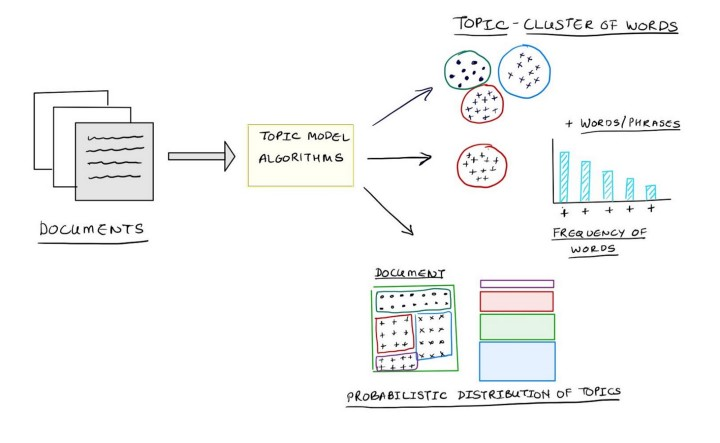

In [ ]:
def display_topics(model, feature_names, no_top_words): 
  for topic_idx, topic in enumerate(model.components_): 
    print ("Topic %d:" % (topic_idx)) 
    print (" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])) 

In [ ]:
no_features = 2000

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model 
tf_vectorizer = CountVectorizer(max_df=0.8, max_features=no_features, stop_words='english', ngram_range=(1,1)) 
tf = tf_vectorizer.fit_transform(X_train['Body'])
tf_test = tf_vectorizer.transform(X_test['Body'])
tf_anomaly = tf_vectorizer.transform(anomaly_df['Body']) 
tf_feature_names = tf_vectorizer.get_feature_names()

In [ ]:
no_topics = 30 
no_iter = 200 
# Run LDA 
lda = LatentDirichletAllocation(n_components=no_topics, 
                                max_iter=no_iter, 
                                learning_method='online', 
                                learning_offset=50., 
                                random_state=0).fit(tf) 

no_top_words = 10 
display_topics(lda, tf_feature_names, no_top_words) 

Topic 0:
kay check hi city just look ll thought don need
Topic 1:
kay thanks tomorrow meeting conference friday discuss ben available afternoon
Topic 2:
plant said energy environmental duke st power money use state
Topic 3:
kay interested just arrange ll thought monday scheduled available anytime
Topic 4:
agreement ena party shall purchase payment assignment enron agent equipment
Topic 5:
kay thanks number fax send need print copy john letter
Topic 6:
deal help speak area handled boyd lm directly perc expertise
Topic 7:
fuel power cell company energy gas cells fuelcell percent market
Topic 8:
good fyi sounds like kay didn maybe checked check discussed
Topic 9:
kay ge thanks agreement contract need version draft hi letter
Topic 10:
ena enron eecc legal counsel power outside review working involved
Topic 11:
right person far job enovate make looking ve figured chicago
Topic 12:
new year called early run york said game end based
Topic 13:
pm ca gregg going kay penman account big opps aren

In [ ]:
topic_df = lda.transform(tf)
topic_df_test = lda.transform(tf_test)
topic_df_anomaly = lda.transform(tf_anomaly) 
print(topic_df.shape)
print(topic_df_test.shape)
print(topic_df_anomaly.shape) 

(5084, 30)
(1271, 30)
(9, 30)


### 3) Anomaly detection by Autoencoder

Autoencoder is used for unsupervised anomaly detection. By learning to replicate the features in the training data, the model is encouraged to learn how to precisely reproduce the features. When facing anomalies, the model should worsen its reconstruction performance. By comparing input features and replicated output features, discrepancies can be used as an indicator of anomalies.

The architecture of autoencoder is shown below:

![alt text](https://drive.google.com/uc?id=1mhbleDHwhNNMtKugG53VUFywWukKEHVm)

In [ ]:
X1_dense = X_PCA 
X2_dense = np.concatenate((X1_dense, topic_df),axis=1) 
X1_dense_test = X_PCA_test 
X2_dense_test = np.concatenate((X1_dense_test, topic_df_test),axis=1) 
num_of_encoder = X2_dense.shape[1] 
num_of_hidden = int(X2_dense.shape[1]/2) 
print(X2_dense.shape) 

# input placeholder
input_img = tfl.keras.layers.Input(shape=(num_of_encoder,))

# this is the encoded representation of the input
encoded = tfl.keras.layers.Dense(num_of_hidden*1.5, activation='relu', 
                                 kernel_initializer=tfl.keras.initializers.he_normal(seed=None))(input_img)

# this is the encoded representation of the input
encoded1 = tfl.keras.layers.Dense(num_of_hidden, activation='relu')(encoded)

# this is the encoded representation of the input
encoded2 = tfl.keras.layers.Dense(num_of_hidden*1.5, activation='relu')(encoded1)

# this is the loss reconstruction of the input
decoded = tfl.keras.layers.Dense(num_of_encoder, activation='tanh')(encoded2)

# this model maps an input to its recommendation
autoencoder = tfl.keras.models.Model(input_img, decoded)
autoencoder.summary()

(5084, 230)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 230)]             0         
_________________________________________________________________
dense (Dense)                (None, 172)               39732     
_________________________________________________________________
dense_1 (Dense)              (None, 115)               19895     
_________________________________________________________________
dense_2 (Dense)              (None, 172)               19952     
_________________________________________________________________
dense_3 (Dense)              (None, 230)               39790     
Total params: 119,369
Trainable params: 119,369
Non-trainable params: 0
_________________________________________________________________


In [ ]:
opt = tfl.keras.optimizers.RMSprop(learning_rate=0.01, rho=0.9)
autoencoder.compile(optimizer=opt, loss='mean_squared_error')

In [ ]:
# simple early stopping
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
# fit model
autoencoder.fit(X2_dense, X2_dense, epochs=10000, batch_size=1028, shuffle=True, 
                validation_data=(X2_dense, X2_dense))

Streaming output truncated to the last 5000 lines.
Epoch 7501/10000
5/5 [==============================] - 0s 17ms/step - loss: 0.3688 - val_loss: 0.3697
Epoch 7502/10000
5/5 [==============================] - 0s 17ms/step - loss: 0.3698 - val_loss: 0.3717
Epoch 7503/10000
5/5 [==============================] - 0s 17ms/step - loss: 0.3747 - val_loss: 0.3706
Epoch 7504/10000
5/5 [==============================] - 0s 18ms/step - loss: 0.3708 - val_loss: 0.3723
Epoch 7505/10000
5/5 [==============================] - 0s 17ms/step - loss: 0.3722 - val_loss: 0.3715
Epoch 7506/10000
5/5 [==============================] - 0s 19ms/step - loss: 0.3720 - val_loss: 0.3697
Epoch 7507/10000
5/5 [==============================] - 0s 17ms/step - loss: 0.3736 - val_loss: 0.3730
Epoch 7508/10000
5/5 [==============================] - 0s 18ms/step - loss: 0.3728 - val_loss: 0.3740
Epoch 7509/10000
5/5 [==============================] - 0s 17ms/step - loss: 0.3770 - val_loss: 0.3687
Epoch 7510/10000
5/5 [

In [ ]:
def key_consine_similarity(tupple): 
  return tupple[1] 
def get_computed_similarities(vectors, predicted_vectors, reverse=False): 
  data_size = len(vectors) 
  cosine_similarities = [] 
  for i in range(data_size): 
    cosine_sim_val = (1 - cosine(vectors[i], predicted_vectors[i])) 
    cosine_similarities.append((i, cosine_sim_val)) 
  return sorted(cosine_similarities, key=key_consine_similarity, reverse=False) 

In [ ]:
def display_top_n(sorted_cosine_similarities, n=5): 
  for i in range(n): 
    index, consine_sim_val = sorted_cosine_similarities[i] 
    print('Subject: ', email_df.iloc[index, 0]) 
    print('Cosine Sim Val :', consine_sim_val) 
    print('----------------------------------') 

In [ ]:
# For normal process 
X1_dense = X_PCA 
X2_dense = np.concatenate((X1_dense, topic_df),axis=1) 
print(X1_dense.shape) 
print(X2_dense.shape)
predicted_vectors = autoencoder.predict(X2_dense) 
mse = np.mean(np.power(X2_dense - predicted_vectors, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse})
error_df.describe()

(5084, 200)
(5084, 230)


,reconstruction_error
count,5084.000000
mean,0.371161
std,0.144513
min,0.018380
25%,0.275169
50%,0.354693
75%,0.455845
max,1.055469


In [ ]:
X1_anomaly_PCA = np.concatenate((X_anomaly_PCA, topic_df_anomaly),axis=1) 
print(X1_anomaly_PCA.shape) 
X2_dense = np.concatenate((X2_dense, X1_anomaly_PCA),axis=0) 
print(X2_dense.shape) 
predicted_vectors = autoencoder.predict(X2_dense) 

(9, 230)
(5093, 230)


In [ ]:
data_size = len(predicted_vectors) 
cosine_similarities = [] 
for i in range(data_size): 
  cosine_sim_val = (1 - cosine(X2_dense[i], predicted_vectors[i])) 
  cosine_similarities.append((i, cosine_sim_val)) 

#cosine_similarities = pd.DataFrame(cosine_similarities, columns=rnumi, 'Cos_Sim']) 
#coords = PCA(n_components=2).fit_transform(predicted_vectors) 
df3 = X_train[['Subject', 'Body', 'Body_Original','From']] 
s = pd.Series([16941,16942,16943,16944,16945,16946,16947,16948,16949]) 
anomaly_df.set_index(s, inplace=True) 
df3 = pd.concat([df3, anomaly_df[['Subject','Body', 'Body_Original','From']]], axis=0) 
df3.reset_index(level=0, inplace=True) 
print(df3.shape) 
#print(len(coords)) 
print(len(cosine_similarities)) 
df3 = np.concatenate([df3, cosine_similarities], axis=1) 
df3 = pd.DataFrame(df3) 
df3.set_index(df3.columns[0], inplace=True) 
df3.rename(columns={df3.columns[0]:'Subject', 
                    df3.columns[1]:'Body', 
                    df3.columns[2]:'Body_Original', 
                    df3.columns[3]:'From',  
                    df3.columns[4]:'Num',
                    df3.columns[5]:'Cos_Sim'}, inplace=True) 

(5093, 5)
5093


In [ ]:
#X1_dense = X_copy.todense() 
X1_dense = X_PCA 
X1_dense = np.concatenate((X1_dense, topic_df),axis=1) 
#X1_anomaly = np.concatenate((X_anomaly, topic_df_anomaly),axis=1) 
#X1_dense = np.concatenate((X1_dense, X1_anomaly),axis=0) 
print(X1_dense.shape) 
predicted_vectors = autoencoder.predict(X1_dense) 
print('Top 5 unique emails') 
sorted_cosine_similarities = get_computed_similarities(vectors=X1_dense, predicted_vectors=predicted_vectors) 
display_top_n(sorted_cosine_similarities=sorted_cosine_similarities, n =5) 
df3.loc[df3['Subject'] == 'Test-Misconduct', 'Outlier'] = 'Y' 
df3.loc[df3['Subject'] != 'Test-Misconduct', 'Outlier'] = 'N' 

(5084, 230)
Top 5 unique emails
Subject:  kay.mann@enron.com
Cosine Sim Val : 0.171354687102251
----------------------------------
Subject:  kay.mann@enron.com
Cosine Sim Val : 0.2754779752675892
----------------------------------
Subject:  kay.mann@enron.com
Cosine Sim Val : 0.29589220934332827
----------------------------------
Subject:  kay.mann@enron.com
Cosine Sim Val : 0.3131562195629938
----------------------------------
Subject:  kay.mann@enron.com
Cosine Sim Val : 0.3131562195629938
----------------------------------


(0.0, 1.0)

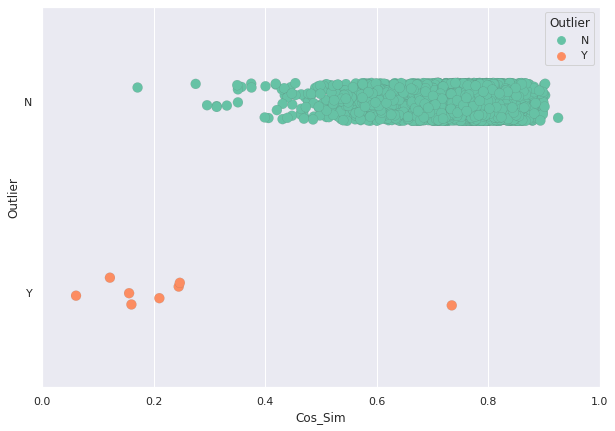

In [ ]:
sns.set(rc={'figure.figsize':(10,7)})  
g = sns.stripplot(x='Cos_Sim', y='Outlier', hue='Outlier', data=df3[['Cos_Sim','Outlier']], jitter=0.1, linewidth=0.1, palette="Set2", size=10,) 
g. set_xlim([0,1]) 

### Reference:

1) https://towardsdatascience.com/applying-machine-learning-to-classify-an-unsupervised-text-document-e7bb6265f52

2) http://rohitapte.com/2019/04/04/stylometric-analysis/

3) https://www.tutorialspoint.com/python/python_extract_url_from_text.htm

4) https://medium.comi@rnbrown/more-nlp-with-sklearns-countvectorizer-add577a0b8c8

5) https://medium.com/analytics-vidhya/automated-keyword-extraction-from-articles-using-nlp-bfd864f41b34

6) https://en.wikipedia.org/wiki/Tf%E2%80%93idf

7) https://medium.com/mlreview/topic-modeling-with-scikit-learn-e80d33668730

8) https://medium.com/datadriveninvestor/unsupervised-outlier-detection-in-text-corpus-using-deep-learning-41d4284a04c8

9) https://en.wikipedia.org/wiki/Autoencoder